In [1]:
import operator
import os
from typing import Literal, TypedDict, Annotated, List
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import START, END, StateGraph

# Load API Key
load_dotenv()
# Ensure OPENAI_API_KEY is set in your environment
# os.environ["OPENAI_API_KEY"] = "sk-..." 

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- Define a simple tool for the Executor to use ---
@tool
def search(query: str) -> str:
    """Search for information."""
    # Mock knowledge base for the exercise
    knowledge = {
  "ai definition": "Artificial Intelligence refers to machines designed to simulate human intelligence, enabling them to learn, reason, and make decisions.",
  "ai applications": "AI is used in areas such as healthcare, finance, education, transportation, and customer support for automation and predictive analysis.",
  "summary": "AI enhances efficiency and decision-making by enabling machines to perform intelligent tasks."
    }
    
    query_lower = query.lower()
    results = []
    for k, v in knowledge.items():
        if k in query_lower or query_lower in k:
            results.append(v)
            
    if not results:
        return "No specific details found, but general knowledge suggests AI is popular."
    return "\n".join(results)

tools = [search]
llm_with_tools = llm.bind_tools(tools)

class HybridState(TypedDict):
    # Plan-Execute State
    input: str
    plan: List[str]
    current_step: int
    results: Annotated[List[str], operator.add] 
    
    # Reflection State
    draft: str
    critique: str
    iterations: int
    final_output: str

MAX_REFLECTIONS = 2

In [2]:
# --- 1. Planner Node ---
def planner_node(state: HybridState) -> dict:
    """Generates a step-by-step plan."""
    print(f"\n{'='*20} PLANNER {'='*20}")
    prompt = f"""Task: {state['input']}
    
    Create a concise step-by-step plan to complete this task. 
    Return ONLY a numbered list of steps (e.g., '1. Step one').
    Keep it to 3-4 steps max.
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    
    # Simple parsing logic
    steps = [line.strip() for line in response.content.split('\n') 
             if line.strip() and line[0].isdigit()]
    
    print("📋 Plan Created:")
    for step in steps:
        print(f"  {step}")
        
    return {
        "plan": steps, 
        "current_step": 0, 
        "results": [],
        "iterations": 0 # Initialize reflection counter
    }

# --- 2. Executor Node ---
def executor_node(state: HybridState) -> dict:
    """Executes the current step in the plan."""
    current_step_idx = state['current_step']
    current_step_text = state['plan'][current_step_idx]
    
    print(f"\n⚙️ Executing Step {current_step_idx + 1}: {current_step_text}")
    
    # We ask the LLM to use the tool based on the step
    messages = [
        SystemMessage(content="You are a researcher. Use the search tool to find information."),
        HumanMessage(content=f"Perform this step: {current_step_text}")
    ]
    
    # Trigger tool usage
    ai_msg = llm_with_tools.invoke(messages)
    
    # If tool calls exist, mock execution (or run real tool)
    result_text = ""
    if ai_msg.tool_calls:
        for tc in ai_msg.tool_calls:
            # Manually running the tool for this simple exercise
            if tc['name'] == 'search':
                output = search.invoke(tc['args'])
                result_text += output
    else:
        # If no tool called, just use the LLM's knowledge
        result_text = ai_msg.content

    print(f"   ✓ Result: {result_text[:100]}...")

    return {
        "results": [f"Step {current_step_idx+1}: {result_text}"],
        "current_step": current_step_idx + 1
    }

# --- 3. Generator Node ---
def generator_node(state: HybridState) -> dict:
    """Synthesizes execution results into a first draft."""
    print(f"\n{'='*20} GENERATOR {'='*20}")
    
    context = "\n".join(state['results'])
    prompt = f"""Task: {state['input']}
    
    Research Results:
    {context}
    
    Write a complete draft response based on these results."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print("✍️  Draft Generated.")
    return {"draft": response.content}

# --- 4. Critic Node ---
def critic_node(state: HybridState) -> dict:
    """Critiques the draft against the original task requirements."""
    print(f"\n{'='*20} CRITIC {'='*20}")
    
    prompt = f"""Task: {state['input']}
    Draft: {state['draft']}
    
    Critique this draft. Does it fully satisfy the task? 
    Is it beginner-friendly?
    
    If it is perfect, respond with exactly 'APPROVED'.
    Otherwise, list specific improvements needed."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print(f"🔍 Critique: {response.content[:100]}...")
    
    return {
        "critique": response.content,
        "iterations": state['iterations'] + 1
    }

# --- 5. Refiner Node ---
def refiner_node(state: HybridState) -> dict:
    """Improves the draft based on critique."""
    print(f"\n{'='*20} REFINER (Iteration {state['iterations']}) {'='*20}")
    
    prompt = f"""Task: {state['input']}
    Current Draft: {state['draft']}
    Critique: {state['critique']}
    
    Rewrite the draft to address the critique."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print("✨ Draft Refined.")
    
    return {"draft": response.content}

# --- 6. Finalizer Node ---
def finalizer_node(state: HybridState) -> dict:
    """Outputs the final result."""
    print(f"\n{'='*20} FINALIZER {'='*20}")
    return {"final_output": state['draft']}

In [3]:
# --- Routing Logic ---

def should_continue_execution(state: HybridState) -> Literal["executor", "generator"]:
    """Loop executor until plan is finished."""
    if state['current_step'] < len(state['plan']):
        return "executor"
    return "generator"

def should_refine(state: HybridState) -> Literal["refiner", "finalizer"]:
    """Decide whether to refine or finalize."""
    if "APPROVED" in state['critique'] or state['iterations'] > MAX_REFLECTIONS:
        return "finalizer"
    return "refiner"

# --- Build Graph ---
builder = StateGraph(HybridState)

# Add Nodes
builder.add_node("planner", planner_node)
builder.add_node("executor", executor_node)
builder.add_node("generator", generator_node)
builder.add_node("critic", critic_node)
builder.add_node("refiner", refiner_node)
builder.add_node("finalizer", finalizer_node)

# Add Edges
builder.add_edge(START, "planner")
builder.add_edge("planner", "executor")

# Conditional Edge: Execution Loop
builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "generator": "generator"}
)

builder.add_edge("generator", "critic")

# Conditional Edge: Reflection Loop
builder.add_conditional_edges(
    "critic",
    should_refine,
    {"refiner": "refiner", "finalizer": "finalizer"}
)

builder.add_edge("refiner", "critic") # Loop back for re-evaluation
builder.add_edge("finalizer", END)

# Compile
graph = builder.compile()

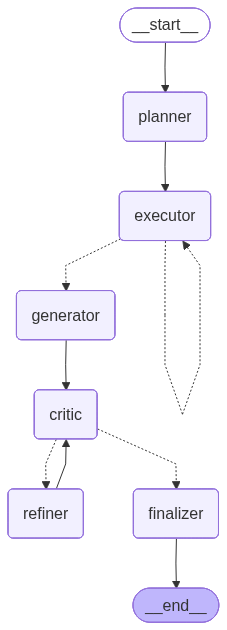

In [4]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass
# Graph structure: 
# Planner -> Executor (loops) -> Generator -> Critic <-> Refiner -> Finalizer -> END

In [5]:
scenario = "Research the benefits of Artificial Intelligence, create a summary, and make it beginner-friendly"

print(f"🚀 STARTING AGENT\nTask: {scenario}")

result = graph.invoke({
    "input": scenario
})

print(f"\n\n{'='*70}")
print("📊 FINAL OUTPUT")
print(f"{'='*70}")
print(result['final_output'])

🚀 STARTING AGENT
Task: Research the benefits of Artificial Intelligence, create a summary, and make it beginner-friendly

==================== PLANNER ====================
📋 Plan Created:
  1. Identify key benefits of Artificial Intelligence, such as efficiency, accuracy, and automation.
  2. Research and gather simple explanations and examples for each benefit to make them easy to understand.
  3. Summarize the findings into a clear and concise overview, using beginner-friendly language.
  4. Review and refine the summary to ensure clarity and accessibility for a general audience.

⚙️ Executing Step 1: 1. Identify key benefits of Artificial Intelligence, such as efficiency, accuracy, and automation.
   ✓ Result: No specific details found, but general knowledge suggests AI is popular....

⚙️ Executing Step 2: 2. Research and gather simple explanations and examples for each benefit to make them easy to understand.
   ✓ Result: No specific details found, but general knowledge suggests AI